Small, simple example

In [2]:
from trajectree.fock_optics.utils import create_vacuum_state
from trajectree.fock_optics.measurement import create_threshold_POVM_OP_Dense, rotate_and_measure, create_PNR_POVM_OP_Dense
from trajectree.fock_optics.outputs import read_quantum_state
from trajectree.fock_optics.noise_models import depolarizing_operators
from trajectree.fock_optics.devices import rx, rz, ry, global_phase

from trajectree.trajectory import trajectory_evaluator, quantum_channel

import numpy as np
import qutip as qt
from scipy import sparse as sp
from quimb.tensor.tensor_arbgeom import tensor_network_apply_op_vec #type: ignore
from quimb.tensor import MatrixProductOperator as mpo #type: ignore

/home/asingal/home/.venv/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
/home/asingal/home/.venv/lib/python3.10/site-packages/cotengra/hyperoptimizers/hyper.py:33: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(


In [3]:
def create_perfect_H_state(N=2, error_tolerance = 1e-10):
    # Defining the control and target inputs here
    a_dag = qt.create(N).full()
    I = qt.identity(N).full()

    a_H = np.kron(I, a_dag)
    a_V = np.kron(a_dag, I)

    # Testing the case with only one MPS for both control and target
    vacuum = create_vacuum_state(num_modes=2, N=N)
    pure_H_operator = a_H
    pure_H_operator_MPO = mpo.from_dense(pure_H_operator, dims = N, sites = (0,1), L=2, tags="ideal_state")    
    psi = tensor_network_apply_op_vec(pure_H_operator_MPO, vacuum, compress=True, contract = True, cutoff = error_tolerance)
    return psi

In [4]:
N = 2
psi = create_perfect_H_state(N)
read_quantum_state(psi, N, num_states=1)

Corresponding Basis terms:
1H0V_A - 1 - [1.+0.j]


In [5]:
depol_ops = depolarizing_operators(0.5, N, bias = (5/10, 2/10, 3/10))
NOT_MPO = rx(np.pi, N, return_unitary = False, site1 = 0, site2 = 1, total_sites=2)
phase_flip_ops = [np.sqrt(0.5) * sp.csr_matrix(rz(np.pi, N, return_unitary = True, site1 = 0, site2 = 1, total_sites = 2)), 
                  np.sqrt(0.5) * sp.csr_matrix(global_phase(0, N, return_unitary = True, site1 = 0, site2 = 1, total_sites = 2))]
RY_MPO = ry(np.pi, N, return_unitary = False, site1 = 0, site2 = 1, total_sites=2)

print("depolarization operators")
print(np.round(depol_ops[0].toarray(), 2))
print(np.round(depol_ops[1].toarray(), 2))
print(np.round(depol_ops[2].toarray(), 2))
print(np.round(depol_ops[3].toarray(), 2))
print("Not MPO")
print(np.round(NOT_MPO.to_dense(), 2))
print("Phase flip operators")
print(np.round(phase_flip_ops[0].toarray(), 2))
print(np.round(phase_flip_ops[1].toarray(), 2))
print("Initial state")
print(psi.to_dense())

depolarization operators
[[0.71 0.   0.   0.  ]
 [0.   0.71 0.   0.  ]
 [0.   0.   0.71 0.  ]
 [0.   0.   0.   0.71]]
[[0.5+0.j  0. +0.j  0. +0.j  0. +0.j ]
 [0. +0.j  0. +0.j  0. -0.5j 0. +0.j ]
 [0. +0.j  0. -0.5j 0. +0.j  0. +0.j ]
 [0. +0.j  0. +0.j  0. +0.j  0.5+0.j ]]
[[ 0.32+0.j  0.  +0.j  0.  +0.j  0.  +0.j]
 [ 0.  +0.j  0.  +0.j -0.32+0.j  0.  +0.j]
 [ 0.  +0.j  0.32+0.j  0.  +0.j  0.  +0.j]
 [ 0.  +0.j  0.  +0.j  0.  +0.j  0.32+0.j]]
[[0.39+0.j   0.  +0.j   0.  +0.j   0.  +0.j  ]
 [0.  +0.j   0.  -0.39j 0.  +0.j   0.  +0.j  ]
 [0.  +0.j   0.  +0.j   0.  +0.39j 0.  +0.j  ]
 [0.  +0.j   0.  +0.j   0.  +0.j   0.39+0.j  ]]
Not MPO
[[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.-1.j 0.+0.j]
 [0.+0.j 0.-1.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j]]
Phase flip operators
[[0.71+0.j   0.  +0.j   0.  +0.j   0.  +0.j  ]
 [0.  +0.j   0.  -0.71j 0.  +0.j   0.  +0.j  ]
 [0.  +0.j   0.  +0.j   0.  +0.71j 0.  +0.j  ]
 [0.  +0.j   0.  +0.j   0.  +0.j   0.71+0.j  ]]
[[0.71+0.j 0.  +0.j 

In [ ]:
quantum_channel_list = []
quantum_channel_list.append(quantum_channel(N = N, num_modes = 2, formalism = "kraus", kraus_ops_tuple = ((0,1), depol_ops), name = "depolarization"))
quantum_channel_list.append(quantum_channel(N = N, num_modes = 2, formalism = "closed", unitary_MPOs = NOT_MPO))
quantum_channel_list.append(quantum_channel(N = N, num_modes = 2, formalism = "kraus", kraus_ops_tuple = ((0,1), phase_flip_ops), name = "Phase flip"))
quantum_channel_list.append(quantum_channel(N = N, num_modes = 2, formalism = "closed", unitary_MPOs = RY_MPO))
# quantum_channel_list
evaluator = trajectory_evaluator(quantum_channels = quantum_channel_list)


Here, we expect the output density matrix from the depolarization channel to be: 

$
\sqrt{0.5} * \ket{1H}\bra{1H} +\\
-1j * \sqrt{0.25} * \ket{1V}\bra{1V} +\\
\sqrt{0.1} * \ket{1V}\bra{1V} + \\
-1j * \sqrt{0.15} * \ket{1H}\bra{1H} \\
=\\
0.71  * \ket{1H}\bra{1H} +\\
-0.5j * \ket{1V}\bra{1V} +\\
.32 * \ket{1V}\bra{1V} +\\ 
-.387j * \ket{1H}\bra{1H}\\
$
and after the RX, the DM becomes:<br>
$
-0.71j * \ket{1V}\bra{1V} +\\
-0.5 *   \ket{1H}\bra{1H} +\\
-.32j *  \ket{1H}\bra{1H} + \\
-.387  *  \ket{1V}\bra{1V}\\
$
After the dephasing channel, the DM becomes:<br>
$
(0,0)~~ 0.5 \ket{1V}\bra{1V} +\\ 
(1,0)~~ 0.3535j \ket{1H}\bra{1H} +\\ 
(2,0)~~ -0.226 \ket{1H}\bra{1H} +\\
(3,0)~~ -.273j \ket{1V}\bra{1V} +\\ 
(0,1)~~ -0.5j \ket{1V}\bra{1V} +\\
(1,1)~~ -0.3535 \ket{1H}\bra{1H} +\\
(2,1)~~ -.226j \ket{1H}\bra{1H} +\\
(3,1)~~ -.273 \ket{1V}\bra{1V} +\\
$
After the Y gate, the DM becomes:<br>
$
(0,0)~~ -0.5 \ket{1H}\bra{1H} +\\ 
(1,0)~~ 0.3535j \ket{1V}\bra{1V} +\\ 
(2,0)~~ -0.226 \ket{1V}\bra{1V} +\\
(3,0)~~ .273j \ket{1H}\bra{1H} +\\ 
(0,1)~~ 0.5j \ket{1H}\bra{1H} +\\
(1,1)~~ -0.3535 \ket{1V}\bra{1V} +\\
(2,1)~~ -.226j \ket{1V}\bra{1V} +\\
(3,1)~~ .273 \ket{1H}\bra{1H} +\\
$

In [6]:
psi_new = evaluator.perform_simulation(psi, error_tolerance = 1e-10, cache = True, trajectree_indices = [0,0], normalize = False)
read_quantum_state(psi_new, N, num_states=1)
psi_new = evaluator.perform_simulation(psi, error_tolerance = 1e-10, cache = True, trajectree_indices = [1,0], normalize = False)
read_quantum_state(psi_new, N, num_states=1)
psi_new = evaluator.perform_simulation(psi, error_tolerance = 1e-10, cache = True, trajectree_indices = [2,0], normalize = False)
read_quantum_state(psi_new, N, num_states=1)
psi_new = evaluator.perform_simulation(psi, error_tolerance = 1e-10, cache = True, trajectree_indices = [3,0], normalize = False)
read_quantum_state(psi_new, N, num_states=1)
psi_new = evaluator.perform_simulation(psi, error_tolerance = 1e-10, cache = True, trajectree_indices = [0,1], normalize = False)
read_quantum_state(psi_new, N, num_states=1)
psi_new = evaluator.perform_simulation(psi, error_tolerance = 1e-10, cache = True, trajectree_indices = [1,1], normalize = False)
read_quantum_state(psi_new, N, num_states=1)
psi_new = evaluator.perform_simulation(psi, error_tolerance = 1e-10, cache = True, trajectree_indices = [2,1], normalize = False)
read_quantum_state(psi_new, N, num_states=1)
psi_new = evaluator.perform_simulation(psi, error_tolerance = 1e-10, cache = True, trajectree_indices = [3,1], normalize = False)
read_quantum_state(psi_new, N, num_states=1)

print(evaluator.cache_hit, evaluator.cache_miss, evaluator.cache_partial_hit)

Corresponding Basis terms:
1H0V_A - 1 - [-0.5+0.j]
Corresponding Basis terms:
0H1V_A - 2 - [-0.+0.35355339j]
Corresponding Basis terms:
0H1V_A - 2 - [-0.2236068-0.j]
Corresponding Basis terms:
1H0V_A - 1 - [0.+0.27386128j]
Corresponding Basis terms:
1H0V_A - 1 - [0.+0.5j]
Corresponding Basis terms:
0H1V_A - 2 - [-0.35355339+0.j]
Corresponding Basis terms:
0H1V_A - 2 - [-0.-0.2236068j]
Corresponding Basis terms:
1H0V_A - 1 - [0.27386128+0.j]
7 5 4


In [20]:
psi_new = evaluator.perform_simulation(psi, error_tolerance = 1e-10, cache = True, normalize = False)
read_quantum_state(psi_new, N, num_states=1)


Corresponding Basis terms:
0H1V_A - 2 - [-0.35355339+0.j]


Swapping simulations:

In [1]:
from trajectree.sequence.swap import perform_swapping_simulation
# import trajectree

import numpy as np
from matplotlib import pyplot as plt

In [5]:
# Set simulation params
trunc = 2
N = trunc+1
error_tolerance = 1e-7

params = {
    "PA_det_eff": 0.5,
    "BSM_det_loss_1": 0.5, #  0.045,
    "BSM_det_loss_2": 0.5, # 0.135,
    "BSM_dark_counts_1": 1,
    "BSM_dark_counts_2": 1,
    "alpha_list": np.array([np.pi/2]),
    "delta_list": np.array([np.pi/2]),
    "channel_loss": 0,
    "chi": 0.24,
    "BSM_meas": {0:(2,3), 1:(6,7)},

    "if_analyze_entanglement": False,
    "calc_fidelity": True,
}

num_modes = 8
# Create vacuum state
 
# idler_angles = np.linspace(0, np.pi, 1)
# signal_angles = np.linspace(0, 4*np.pi, 30)

num_simulations = 150
visibilities = []

cache_sizes = [2]

for i in [3e-5]: # np.linspace(0.1, 0.5, 5):
    prob_same_phase = 0
    prob_diff_phase = 0

    # params['chi'] = i
    params["BSM_dark_counts_1"] = 1+i
    params["BSM_dark_counts_2"] = 1+i

    params["alpha_list"] = np.array([np.pi/2])

    fidelities, probabilities, t_eval = perform_swapping_simulation(N, num_modes, num_simulations, params = params, error_tolerance = error_tolerance)
    print(probabilities)
    prob_same_phase += np.mean(probabilities)

    params["alpha_list"] = np.array([3*np.pi/2])

    fidelities, probabilities, t_eval = perform_swapping_simulation(N, num_modes, num_simulations, params = params, error_tolerance = error_tolerance)
    print(probabilities)
    prob_diff_phase += np.mean(probabilities)

    visibilities.append((prob_same_phase - prob_diff_phase) / (prob_same_phase + prob_diff_phase))
# params["BSM_meas"] = {1:(2,3), 0:(6,7)}

# fidelities, probabilities, t_eval = perform_swapping_simulation(N, num_modes, num_simulations, params = params, error_tolerance = error_tolerance)
# prob_diff_phase += np.mean(probabilities)

# params["alpha_list"] = np.array([np.pi/2])

# fidelities, probabilities, t_eval = perform_swapping_simulation(N, num_modes, num_simulations, params = params, error_tolerance = error_tolerance)
# prob_same_phase += np.mean(probabilities)

C:\Users\anshs\OneDrive - Northwestern University\Study\Argonne\QCE25\Trajectree\trajectree\fock_optics\measurement.py:84: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  dense_op = sqrtm(create_threshold_POVM_OP_Dense(efficiency, outcome, N)).astype(np.complex128)


trajectory_probs [1.]
trajectory_probs [1.]
trajectory_probs [9.43729766e-01 2.69904807e-02 7.37107472e-04 2.69905007e-02
 7.71884510e-04 2.10730941e-05 7.37107874e-04 2.10693882e-05
 5.73300612e-07]
trajectory_probs [8.90742284e-01 2.54161074e-02 6.94852873e-04 2.54160866e-02
 7.25193429e-04 1.98367250e-05 6.94832567e-04 1.98217130e-05
 5.47350817e-07]
trajectory_probs [8.90687218e-01 2.74196768e-05 7.79324779e-10 2.74196780e-05
 8.44110873e-10 2.39914018e-14 7.79324765e-10 2.39914022e-14
 6.81885914e-19]
trajectory_probs [8.90632191e-01 2.74179817e-05 7.79276627e-10 2.74179807e-05
 8.44058559e-10 2.39899211e-14 7.79276720e-10 2.39899228e-14
 6.81843789e-19]
trajectory_probs [2.54161445e-02 7.25216466e-04 1.98312639e-05 7.85039704e-04
 2.23903683e-05 6.11404458e-07 2.06712884e-05 5.77764587e-07
 1.41152424e-08]
trajectory_probs [2.54145552e-02 7.82383101e-07 2.22369771e-11 8.04100473e-07
 2.47541064e-11 7.03563580e-16 2.16211643e-11 6.65604175e-16
 1.89178832e-20]
trajectory_probs [2.

[np.complex128(-0.006943929227227413+1.8176275948841466e-20j)]


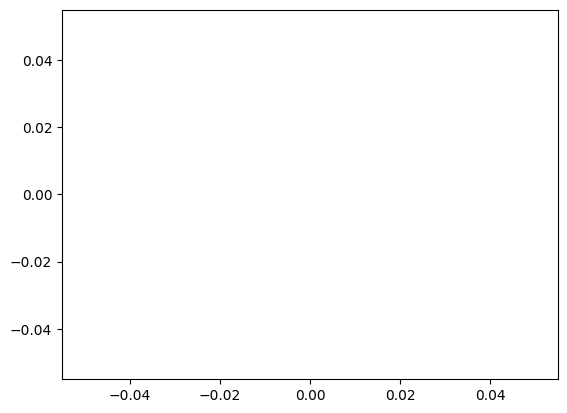

In [6]:
plt.plot(visibilities[1:])
print(visibilities)

In [4]:
(prob_same_phase - prob_diff_phase) / (prob_same_phase + prob_diff_phase)

np.complex128(0.9665257306842052+1.2945563958351387e-20j)